# Notebook to test the new Digitizer class:

1) Tune to get parameters similar to WCSim

2) Tune to get parameters for IWCD electronics

3) Make plots of intermediate steps in digitization


In [1]:
from torch.utils.data import Dataset
import h5py
import numpy as np
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import math
import random
from watchmal.dataset.h5_dataset import H5Dataset, H5TrueDataset
from watchmal.dataset.DigiTruthMapping import DigiTruthMapping, print_time
from watchmal.dataset.Digitizer import Digitizer, get_wf_peak_guesses, pulseshape, plot_fitted_waveform

In [2]:
  
class h5DigiDataSet( H5Dataset ):
    """
    Initialize digihits dataset with basic access to hits, charges and times through the get_data method. 
    """
    def __init__(self, h5_path):
        H5Dataset.__init__( self, h5_path )
               
    def get_data(self, hit_pmts, hit_charges, hit_times):
        return (hit_pmts, hit_charges, hit_times )        
        
class h5TruthWCLikeDataSet( H5TrueDataset ):
    """
    Initializes truehits dataset with basic access to hits, charges and times through the get_data method.
    Use digitization class with parameters set to match WCSim digitization.  Acccess to all of the digitization
    internals is in the instance self.digi.
    """
    def __init__(self, h5_path):
        H5TrueDataset.__init__( self, h5_path )
        self.digi = Digitizer()
        self.digi.bwf_dt = 0.1

    def get_data(self, hit_pmts, hit_charges, hit_times):
        return (hit_pmts, hit_charges, hit_times )   
    
    def digitize(self,truepmts,truetimes,trueparents):
        """
        Overload existing digitization.
        """
        print("h5TruthWCLikeDataSet: digitize event")
        return self.digi.digitize_event( truepmts, truetimes )
    
    def gettruth(self, item):
        if not hasattr(self, 'h5_file'):
            self.open_hdf5()
        
        start             = self.event_hits_index[item]
        stop              = self.event_hits_index[item + 1]
        self.true_pmts    = self.hit_pmt   [start:stop].astype(np.int16)
        self.true_times   = self.time      [start:stop]
        self.true_parents = self.hit_parent[start:stop]

        return (self.true_pmts, self.true_times, self.true_parents )
    

In [3]:
class h5TruthIWCDDataSet( H5TrueDataset ):
    """
    Initializes truehits dataset with basic access to hits, charges and times through the get_data method.
    Use digitization class with parameters set to match WCSim digitization.  Acccess to all of the digitization
    internals is in the instance self.digi.
    """
    def __init__(self, h5_path):
        H5TrueDataset.__init__( self, h5_path )
        self.digi = Digitizer()

    def get_data(self, hit_pmts, hit_charges, hit_times):
        return (hit_pmts, hit_charges, hit_times )   
    
    def digitize(self,truepmts,truetimes,trueparents):
        """
        Overload existing digitization.
        """
        print("h5TruthWCLikeDataSet: digitize event")
        return self.digi.digitize_event( truepmts, truetimes )
    
    def gettruth(self, item):
        if not hasattr(self, 'h5_file'):
            self.open_hdf5()
        
        start             = self.event_hits_index[item]
        stop              = self.event_hits_index[item + 1]
        self.true_pmts    = self.hit_pmt   [start:stop].astype(np.int16)
        self.true_times   = self.time      [start:stop]
        self.true_parents = self.hit_parent[start:stop]

        return (self.true_pmts, self.true_times, self.true_parents )

In [4]:
dataset = h5DigiDataSet( h5_path="/bigdisk/jamieson/IWCD_mPMT_Short/IWCD_mPMT_Short_emg_E0to1000MeV_digihits.h5" ) 
mcset   = h5TruthWCLikeDataSet( h5_path="/bigdisk/jamieson/IWCD_mPMT_Short/IWCD_mPMT_Short_emg_E0to1000MeV_truehits.h5" )
mcset2  = h5TruthIWCDDataSet( h5_path="/bigdisk/jamieson/IWCD_mPMT_Short/IWCD_mPMT_Short_emg_E0to1000MeV_truehits.h5" )

In [5]:
dtm = DigiTruthMapping('data_for_truth.pkl', 'truth_for_data.pkl')

In [6]:
#use new geofile


geofile = np.load('/home/jamieson/ml/geo_mPMTshort.npz',allow_pickle=True)

print("geofile.filse= ",geofile.files)

tubes = geofile[ 'tube_no' ]
print("tubes =", tubes )

tube_xyz = geofile[ 'position' ]
tube_x = tube_xyz[:,0]
tube_y = tube_xyz[:,1]
tube_z = tube_xyz[:,2]
R = (tube_x.max() - tube_x.min())/2.0
H = tube_y.max() - tube_y.min()
Circumference = 2*math.pi*R
Circ2 = math.pi*R
print("R=",R, "H=",H," Circumference=", Circumference, " Circ2=",Circ2)
print( "min_x=",tube_x.min(), "max_x=", tube_x.max(), "diameter=", tube_x.max() - tube_x.min() )
print( "min_z=",tube_z.min(), "max_z=", tube_z.max(), "diameter=", tube_z.max() - tube_z.min() )
print( "min_y=",tube_y.min(), "max_y=", tube_y.max(), "height=", tube_y.max() - tube_y.min() )


geofile.filse=  ['tube_no', 'position', 'orientation']
tubes = [    1     2     3 ... 10182 10183 10184]
R= 399.0980529785156 H= 592.8981323242188  Circumference= 2507.6070225985895  Circ2= 1253.8035112992948
min_x= -399.0980529785156 max_x= 399.0980529785156 diameter= 798.1961059570312
min_z= -399.0980529785156 max_z= 399.0980529785156 diameter= 798.1961059570312
min_y= -296.4490661621094 max_y= 296.4490661621094 height= 592.8981323242188


In [7]:


def PMT_to_flat_cylinder_map_positive( tubes, tube_xyz ):
    """
    Build dictionary of PMT number, to (x,y) on a flat cylinder
    
    N.B. Tube numbers in full geometry file go from 1:NPMTs, but it seems like
    the event data number from 0:NPMTs-1, so subtracting 1 from tube number here?
    
    """
    mapping = {}
    for idx, tube in enumerate(tubes):
        x = tube_xyz[idx,0]
        y = tube_xyz[idx,1]
        z = tube_xyz[idx,2]
        if ( y > 275. ):
            # in top circle of cylinder
            xflat = x+Circ2
            yflat = 1750 + z
            mapping[ int( tube-1 ) ] = [ int(round(xflat)), int(round(yflat)) ]
            
        elif ( y < -275.):
            # in bottom circle of cylinder
            xflat = x+Circ2
            yflat = 350.0 + z
            mapping[ int( tube-1 ) ] = [ int(round(xflat)), int(round(yflat)) ]
            
        else:
            # in barrel part of cylinder
            theta = math.atan2( z, x )
            xflat = R * theta + Circ2
            yflat = y + 1050
            mapping[ int( tube-1 ) ] = [ int(round(xflat)), int(round(yflat)) ]
    return mapping

PMTFlatMapPositive = PMT_to_flat_cylinder_map_positive( tubes, tube_xyz )



Display Events

In [8]:
evno = 0
def GetTrueEvent( mcset, entry ):
    """
    Input is H5TruthData object and entry number.
    Outputs:
    truepmts: np.array of PMT numbers hit, and corresponding
    truetimes: np.array of times PMT was hit
    trueparents: np.array of parent number of photon hitting PMT (-1 for dark noise)
    """
    return mcset.gettruth(entry) 

truepmts, truetimes, trueparent = GetTrueEvent(mcset, evno)

In [9]:
def EventDisplay( tubes, quantities, title="Time", cutrange=[-1,-1] ):
    """
    tubes == np.array of PMTs that were hit
    quantities == np.array of PMT quantities (either charge or time)
    title == title to add to display
    cutrange == minimum and maximum values on plot (or set both same for default)
    """
    
    fig = plt.figure(figsize=[12,12]) 
    preimage = np.zeros( [2200, 2600] )
    #maxquantity = quantities.max()
    #preimage *= maxquantity*1.2
    imgmin = quantities.min()
    imgmax = quantities.max()
    #error here bc cant iterate over the type int32 
    for idx, tube in enumerate( tubes ):
        if cutrange[0] != cutrange[1]:
            if quantities[idx] < cutrange[0] or quantities[idx] > cutrange[1]:
                continue
        for dx in range(-4,5):
            for dy in range(-4,5):
                if abs(dx)==3 and abs(dy)==3:
                    continue
                    
                #print( "idx=", idx, " len(quantities)=",len(quantities), " tube=", tube, " len(PMTFlatMap)=", len(PMTFlatMapPositive))
                preimage[ PMTFlatMapPositive[tube][1]+dx, PMTFlatMapPositive[tube][0]+dy ] = quantities[idx]

    if cutrange[0] != cutrange[1]:
        imgmin = cutrange[0]
        imgmax = cutrange[1]
    plt.imshow( preimage, extent = [-1162.7,1162.7,-1267.7,1267.7], vmin=imgmin, vmax=imgmax )
    fig.suptitle(title, fontsize=20)
    plt.xlabel('Distance CCW on perimeter from x-axis (cm)', fontsize=18)
    plt.ylabel('Y (cm)', fontsize=16)
    #plt.set_cmap('YlGnBu')
    plt.set_cmap('cubehelix')
    #plt.set_cmap('gnuplot2_r')
    #plt.set_cmap('gist_heat_r')
    #plt.set_cmap('inferno_r')
    #plt.set_cmap('pink_r')
    plt.colorbar()
    


Histgrams of the time distributions

In [10]:
#error with hist

def EventDisplayHist( quantities, title="Time", cutrange=[-1,-1] ):
    """
    quantities = np.array of values to histogram
    title = title to add to the histogram
    cutrange = x-axis range to include in histogram
    Makes a histogram with 100 bins
    """
    fig = plt.figure(figsize=[12,12])
    imgmin = quantities.min()
    imgmax = quantities.max()
    if cutrange[0] != cutrange[1]:
        imgmin = cutrange[0]
        imgmax = cutrange[1]
    plt.hist( quantities, 100, [imgmin, imgmax] )
    #fig.suptitle(title, fontsize=20)
    plt.xlabel( title , fontsize=18)
    plt.ylabel('Count / bin', fontsize=16)

#EventDisplayHist( digitimes, "Time")

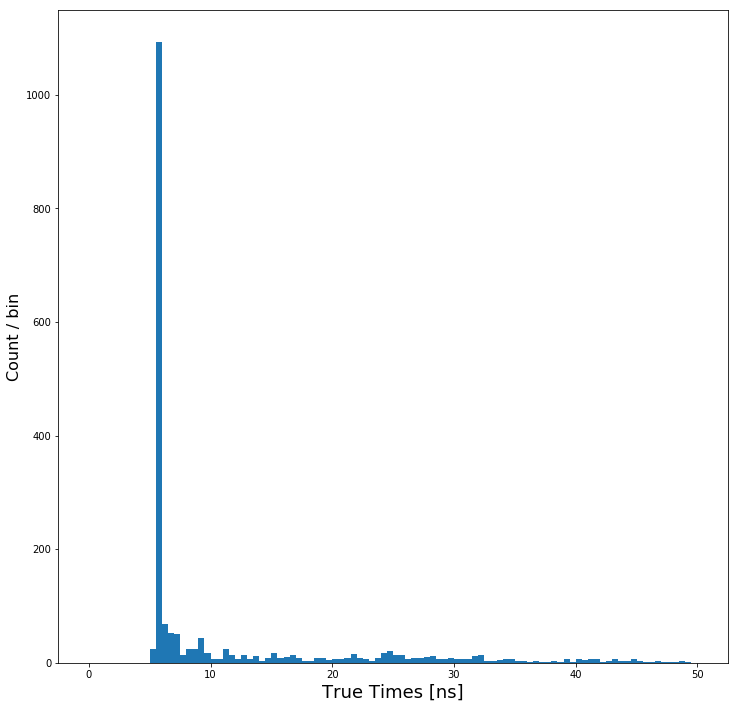

In [11]:
EventDisplayHist( np.array(truetimes), "True Times [ns]", [0.,50.])

# Test intermediate steps in digitization

1. building the waveforms
2. finding peaks (first guess)
3. fitting peaks
4. calculating final charge


In [12]:
item=0
start = mcset.event_hits_index[item]
stop  = mcset.event_hits_index[item + 1]
mcset.true_pmts    = mcset.hit_pmt[start:stop].astype(np.int16)
mcset.true_times   = mcset.time[start:stop]
mcset.true_parents = mcset.hit_parent[start:stop]


mcset.digi.pmt_time_dict = { pmt: mcset.true_times[ mcset.true_pmts==pmt ] for pmt in mcset.true_pmts }
mcset.digi.pmt_pe_dict   = { pmt: mcset.digi.get_pes( len(mcset.true_times[ mcset.true_pmts==pmt ]), mcset.digi.globalqe )  for pmt in mcset.true_pmts }
mcset.digi.pmt_wf_dict   = { pmt: mcset.digi.build_wavetrain( mcset.digi.pmt_time_dict[pmt], 
                                                  mcset.digi.pmt_pe_dict[pmt], 
                                                  mcset.digi.bwf_dt, 
                                                  mcset.digi.bwf_trange, 
                                                  mcset.digi.bwf_dcoffset, 
                                                  mcset.digi.bwf_negpolarity
                                                 ) for pmt in mcset.true_pmts }



Text(0,0.5,'ADC on PMT 420')

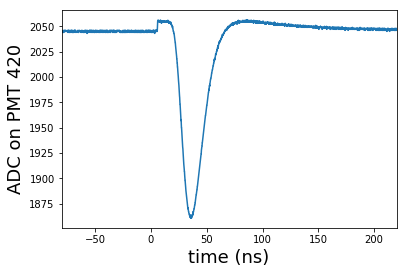

In [13]:
pmts= list( mcset.digi.pmt_wf_dict.keys() )
(t,adc) = mcset.digi.pmt_wf_dict[ pmts[0] ]
plt.plot(t,adc)
plt.xlim(-80,220)
plt.xlabel( 'time (ns)'%pmts[0] , fontsize=18)
plt.ylabel('ADC on PMT %d'%pmts[0], fontsize=18)

times on PMT  420  are  [5.7391157 5.8238564 5.905989  5.8892837 5.7391157 5.9435143 6.0532923
 5.9435143]
pes on PMT  420  are  [0.98166275 1.16328227 0.61313226 1.01245041 0.3188686  1.06600761
 0.83266219 0.44861449]
Total nphotons is  8  total pes is  6.436680575926848


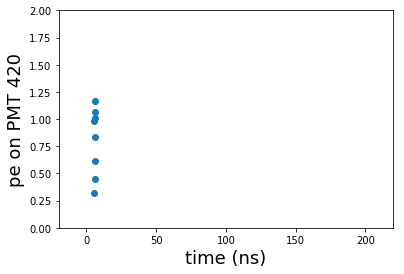

In [14]:
tt = mcset.digi.pmt_time_dict[ pmts[0] ]
pepe = mcset.digi.pmt_pe_dict[ pmts[0] ]
plt.scatter(tt,pepe)
plt.xlim(-20,220)
plt.ylim(0.,2.0)
plt.xlabel( 'time (ns)'%pmts[0] , fontsize=18)
plt.ylabel('pe on PMT %d'%pmts[0], fontsize=18)
print("times on PMT ",pmts[0]," are ",tt)
print("pes on PMT ",pmts[0]," are ",pepe)
print("Total nphotons is ",len(pepe)," total pes is ",np.sum( pepe ) )

baseline= 2044.7515875264587
peak times= [20355]
amplitudes of peaks= [183.75158753]


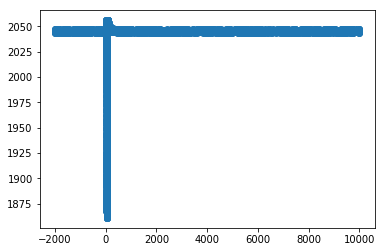

In [15]:
pmt = pmts[0]
pmtwd = mcset.digi.pmt_wf_dict
plt.scatter( pmtwd[pmt][0], pmtwd[pmt][1] )
(bl, tpks, apks) = get_wf_peak_guesses( pmtwd[pmt][0], pmtwd[pmt][1] )
print("baseline=",bl)
print("peak times=",tpks)
print("amplitudes of peaks=",apks)


window_width= 800
twf= [-1975.6 -1975.5 -1975.4 -1975.3 -1975.2 -1975.1 -1975.  -1974.9 -1974.8
 -1974.7 -1974.6 -1974.5 -1974.4 -1974.3 -1974.2 -1974.1 -1974.  -1973.9
 -1973.8 -1973.7]
adcwf= [2045. 2045. 2045. 2045. 2045. 2045. 2045. 2045. 2045. 2046. 2045. 2045.
 2047. 2045. 2045. 2045. 2045. 2045. 2044. 2044.]
sigma= [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
p0= [2044.7515875264587, 183.7515875264587, 35.49999999814872, 10.0]


/home/jamieson/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


baseline= 2044.7515875264587  tbin= 20355  twf[tbin]= 35.49999999814872  apk= 183.7515875264587


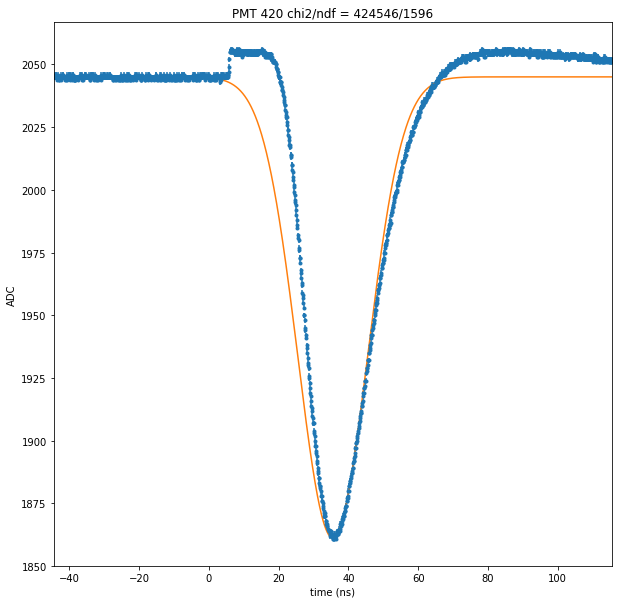

In [16]:
#plt.scatter( pmtwd[pmt][0], pmtwd[pmt][1] )
#plt.xlim(-64,128)
#plt.xlabel( 'time (ns)'%pmts[0] , fontsize=18)
#plt.ylabel('ADC on PMT %d'%pmts[0], fontsize=18)

twf = pmtwd[pmt][0]
adcwf = pmtwd[pmt][1]
dtlocal = twf[1]-twf[0]
window_width = int( 80/dtlocal )
print("window_width=",window_width)
adcwferr = 1.0
adcwferrs = adcwferr*np.ones( window_width*2 )

tbin=tpks[0]
apk=apks[0]
tmin=244
tmax=264
print("twf=",twf[tmin:tmax])
print("adcwf=",adcwf[tmin:tmax])
print("sigma=",adcwferrs[0:tmax-tmin])
print("p0=",[bl, apk, twf[ tbin ], 10.0])

try:
    params, covs = curve_fit( pulseshape, 
                          twf[ tmin: tmax], 
                          adcwf[ tmin: tmax],
                          sigma = adcwferrs[0:tmax-tmin],
                          p0 = [bl, apk, twf[ tbin ], 10.0] )
except:
    print("curve_fit failed tbin=",tbin," tmin=",tmin," tmax=",tmax," len(twf)=",len(twf))

plot_fitted_waveform( "PMT %d"%pmt, twf, adcwf, tbin, window_width, params, adcwferr )

print("baseline=",bl, " tbin=",tbin, " twf[tbin]=", twf[tbin], " apk=",apk)

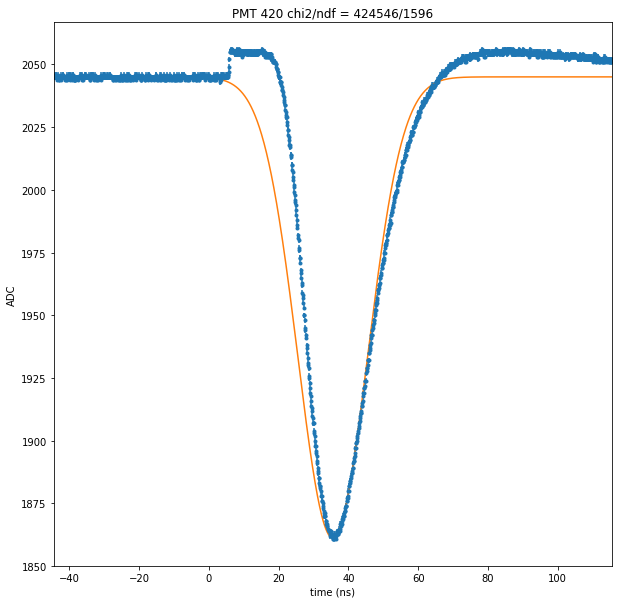

In [ ]:
mcset.digi.curpmt      = pmt
mcset.digi.peakfits    = {}
(tp, qp ) = mcset.digi.get_times_charges_from_wf( pmtwd[pmt][0], pmtwd[pmt][1], mcset.digi.hit_threshold, bl, tpks, apks )
plot_fitted_waveform( "PMT %d"%pmt, twf, adcwf, tbin, window_width, params, adcwferr )

# Built plots of our digitized event vs WCSim

- plot1: WCSim time vs our min-time
- plot2: WCSim charge vs our charge



In [ ]:
# digitize one event to look at
dtitem = 1
mcitem = dtm.get_truth_entry( dtitem )
digipmt, digicharge, digitime = dataset[dtitem]["data"]
ourpmt, ourcharge, ourtime = mcset[mcitem]["data"]
ourpmt2, ourcharge2, ourtime2 = mcset2[mcitem]["data"]

wcsim_times = []
wcsim_charges = []
our_times = []
our_charges = []
for i in range(len(digipmt)):
        pmt = digipmt[i]
        for j in range(len(ourpmt)):
            if pmt == ourpmt[j]:
                wcsim_times.append( digitime[i] )
                wcsim_charges.append( digicharge[i] )
                our_times.append( ourtime[j]  )
                our_charges.append( ourcharge[j] )
                break
    
wcsim_times2 = []
wcsim_charges2 = []
our_times2 = []
our_charges2 = []
for i in range(len(digipmt)):
        pmt = digipmt[i]
        for j in range(len(ourpmt2)):
            if pmt == ourpmt2[j]:
                wcsim_times2.append( digitime[i] )
                wcsim_charges2.append( digicharge[i] )
                our_times2.append( ourtime2[j]  )
                our_charges2.append( ourcharge2[j] )
                break
        
    

h5TruthWCLikeDataSet: digitize event


In [ ]:
pmtsfit = list( mcset.digi.pmt_wf_dict.keys() )
for i in range(10):
    pmt = pmtsfit[i]
    if len( mcset.digi.peakfits[pmt] ) > 0:
        mcset.digi.plot_waveform_fit( pmt )
    

In [ ]:
pmtsfit2 = list( mcset2.digi.pmt_wf_dict.keys() )
for i in range(10):
    pmt = pmtsfit2[i]
    if len( mcset2.digi.peakfits[pmt] ) > 0:
        mcset2.digi.plot_waveform_fit( pmt )

In [ ]:


xvals = np.arange(900,1200,1)
plt.scatter( xvals, xvals)

plt.scatter( wcsim_times, our_times, marker='.')

plt.xlim(900,1100)
plt.ylim(900,1100)
plt.xlabel('WCSim time')
plt.ylabel('Our time')




In [ ]:
#xvals = np.arange(900,1200,1)
#plt.scatter( xvals, xvals)

plt.scatter( wcsim_times2, our_times2, marker='.')

plt.xlim(900,1100)
plt.ylim(900,1100)
plt.xlabel('WCSim time')
plt.ylabel('Our time')


In [ ]:
our_times = np.array(our_times) + 930.0

In [ ]:
import matplotlib.colors as colors
fig = plt.figure(figsize=[12,12])
#plt.scatter( xvals, xvals)
plt.hist2d( wcsim_times, our_times, 1000, [[900, 1200], [900, 1200]],norm=colors.LogNorm(0.5,20000), cmap='cubehelix_r')
#plt.xlim(900,1100)
#plt.ylim(900,1100)
plt.xlabel('WCSim time')
plt.ylabel('Our time')
plt.colorbar()
fig.savefig("times.pdf", bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=[12,12])
plt.hist2d( wcsim_charges, our_charges, 500, [[0,100],[0,100]],norm=colors.LogNorm(0.5,25000), cmap='cubehelix_r')
plt.xlabel('WCSim charge (photo electrons)',fontsize=24)
plt.ylabel('Our charge (arbitrary)',fontsize=24)
plt.colorbar()
fig.savefig("charges.pdf", bbox_inches='tight')